# Some useful simulations

The lane simulations have a lot of parameters, such as `max_acc` (maximum acceleration), `max_vel` (maximum velocity), `safe_dist` (safe distance)... On top of that, they can be run at different time steps `dt`. Many configurations that work are possible, but here are some of the ones that make sense and display some interesting behavior.

In [1]:
from simulator import *

from lanes.OneLane import OneLane
from agents.OneLaneCar import OneLaneCar

import numpy as np

plt.rcParams["figure.figsize"] = (12,5)

### Safe cars

Safe cars follow these simple rules:

1. Compute the distance to the front car.
2. If the distance is greater than the safe distance accelerate to the maximum.
3. Otherwise (the front car is within the safe distance) brake to the maximum.

We will usually set the acceleration much lower than the decceleration, which emulates how cars can brake much faster than they can accelerate. First lets visualize their behavior:

In [2]:
safe_lane_1 = OneLane(1000, [30], ["safe"], OneLaneCar, safe_dist = 20, 
                    accident_dist = 3, max_speed = 5, max_acc = 0.5, min_acc = -3)

simulate_lane(safe_lane_1, steps=1000, dt=1, width=1000, height=200, frame_rate=300)


Lane:  One lane
Total flux:  147
Total accidents:  0

Flux / time:  0.147

Accidents / time:  0.0


As we can see the cars have no problem transcoursing the road with this simple set of rules. However, by adding 5 cars and doubling the maximum speed we see some problems arise: There are jams and the flux decreases.

In [3]:
safe_lane_2 = OneLane(1000, [35], ["safe"], OneLaneCar, safe_dist = 20, 
                    accident_dist = 3, max_speed = 10, max_acc = 0.5, min_acc = -3)

simulate_lane(safe_lane_2, steps=1000, dt=1, width=1000, height=200, frame_rate=60)


Lane:  One lane
Total flux:  113
Total accidents:  0

Flux / time:  0.113

Accidents / time:  0.0


But, how many cars is too many? What maximum speed is too high? How variable is the flux depending on the parameters given? To answer all these questions we can run some more simulations.

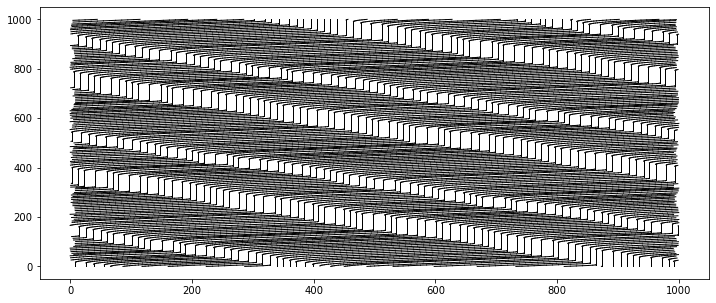

In [4]:
plot_positions(1000, 1, safe_lane_2, linewidth=1)

First of all lets talk about traffic jams. In the above plot each of the lines represents the position of a single car through time. As you can see, eventually traffic jams form and they never dissipate. They leave long straight lines representing the cars being stopped, and they move in the oposite direction to the lane.

Other things we can look at is the flux depending on the car's max speed and max acceleration. Making the max acceleration higher will make cars get out of jams quicklier so we should see an overall increase in flux. However, changing the maximum speed may have negative effects as it might result in traffic jams.

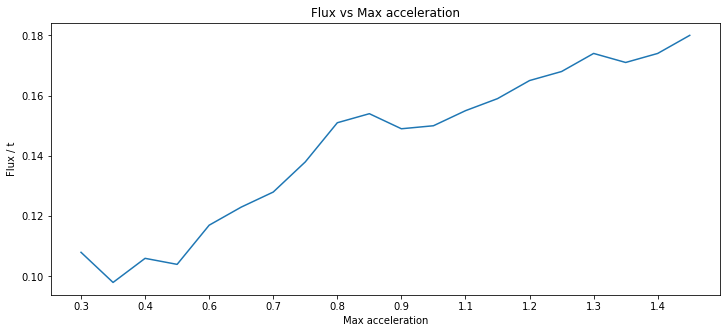

In [5]:
accs = list(np.linspace(0.3, 1.5, 20))
f_a_arr_accs = np.zeros((len(accs), 2))

for i in range(len(accs)):
    lane = OneLane(1000, [35], ["safe"], OneLaneCar, safe_dist = 20, 
                    accident_dist = 3, max_speed = 10, max_acc = accs[i], min_acc = -3)
    # Simulate lane
    _, _, flux, accidents = flux_and_accidents(1000, 1, lane)
    f_a_arr_accs[i, :] = [flux, accidents]

plt.plot(f_a_arr_accs[:, 0])
plt.xlabel("Max acceleration")
plt.ylabel("Flux / t")
plt.xticks(range(0, len(accs), 2), [round(accs[j], 1) for j in range(0, len(accs), 2)])
plt.title("Flux vs Max acceleration")
plt.show()

Just as we expected the flux increases with the max acceleration. However, because of the random variability that results from the randomized initial positions, we want to run the experiments many times to make sure it is consistent.

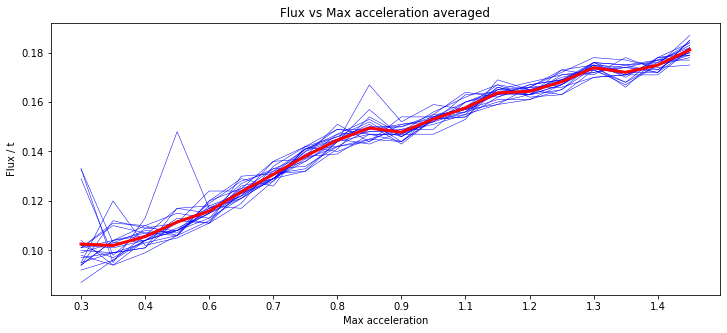

In [6]:
N = 20
accs = list(np.linspace(0.3, 1.5, 20))
flux_avg_accs_safe = np.zeros((len(accs), ))

for n in range(N):
    sim_arr = np.zeros((len(accs), ))
    for i in range(len(accs)):
        lane = OneLane(1000, [35], ["safe"], OneLaneCar, safe_dist = 20, 
                        accident_dist = 3, max_speed = 10, max_acc = accs[i], min_acc = -3)
        # Simulate lane
        _, _, flux, accidents = flux_and_accidents(1000, 1, lane)
        sim_arr[i] = flux

    plt.plot(sim_arr, 'blue', linewidth=.5)
    flux_avg_accs_safe += sim_arr
    
flux_avg_accs_safe /= N
plt.plot(flux_avg_accs_safe, 'red', linewidth=3)

plt.xlabel("Max acceleration")
plt.ylabel("Flux / t")
plt.xticks(range(0, len(accs), 2), [round(accs[j], 1) for j in range(0, len(accs), 2)])
plt.title("Flux vs Max acceleration averaged")
plt.show()

It seems that the results are fairly consistent, and don't have that much of a large variability. Now lets see how the maximum speed affects the flux:

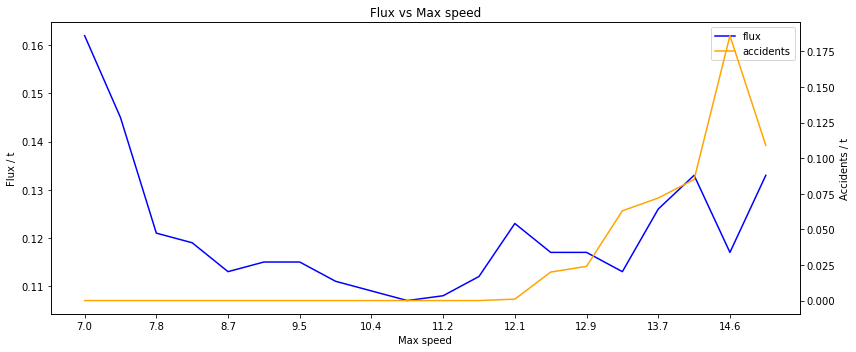

In [7]:
sps = list(np.linspace(7, 15, 20))
flux_avg_sps_safe = np.zeros((len(sps), 2))

for i in range(len(sps)):
    lane = OneLane(1000, [35], ["safe"], OneLaneCar, safe_dist = 20, 
                    accident_dist = 3, max_speed = sps[i], max_acc = 0.5, min_acc = -3)
    # Simulate lane
    _, _, flux, accidents = flux_and_accidents(1000, 1, lane)
    flux_avg_sps_safe[i, :] = [flux, accidents]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ln1 = ax1.plot(flux_avg_sps_safe[:, 0], 'blue')
ln2 = ax2.plot(flux_avg_sps_safe[:, 1], 'orange')
ax1.legend(ln1+ln2, ["flux", "accidents"])
ax1.set_xlabel("Max speed")
ax1.set_ylabel("Flux / t")
ax2.set_ylabel("Accidents / t")
ax1.set_xticks(range(0, len(sps), 2))
ax1.set_xticklabels([round(sps[j], 1) for j in range(0, len(sps), 2)])
plt.title("Flux vs Max speed")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

As we can see, as the maximum speed increases, the flux actually decreases due to jams. After some point the number of accidents also increase. This shows that the values we chose for the maximum speed are a bit extreme. Lets again average the results among many runs but with a different speeds array.

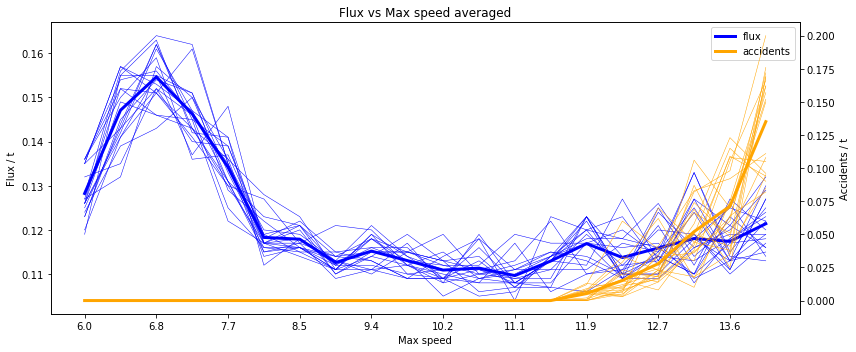

In [8]:
N = 20
sps = list(np.linspace(6, 14, 20))
flux_avg_sps_safe = np.zeros((len(sps), 2))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

for n in range(N):
    sim_arr = np.zeros((len(sps), 2))
    for i in range(len(sps)):
        lane = OneLane(1000, [35], ["safe"], OneLaneCar, safe_dist = 20, 
                        accident_dist = 3, max_speed = sps[i], max_acc = 0.5, min_acc = -3)
        # Simulate lane
        _, _, flux, accidents = flux_and_accidents(1000, 1, lane)
        sim_arr[i, :] = [flux, accidents]

    # plot it with a thin line
    ax1.plot(sim_arr[:, 0], 'blue', linewidth=0.5)
    ax2.plot(sim_arr[:, 1], 'orange', linewidth=0.5)
    flux_avg_sps_safe += sim_arr

flux_avg_sps_safe /= N
# Plot it with a thicker line.
ln1 = ax1.plot(flux_avg_sps_safe[:, 0], 'blue', linewidth=3)
ln2 = ax2.plot(flux_avg_sps_safe[:, 1], 'orange', linewidth=3)
ax1.legend(ln1+ln2, ["flux", "accidents"])
ax1.set_xlabel("Max speed")
ax1.set_ylabel("Flux / t")
ax2.set_ylabel("Accidents / t")
ax1.set_xticks(range(0, len(sps), 2))
ax1.set_xticklabels([round(sps[j], 1) for j in range(0, len(sps), 2)])
plt.title("Flux vs Max speed averaged")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In this case, initially the flux increases as we increase the maximum speed. But at some point (around `max_speed = 7`) the flux peaks and starts decreasing due to traffic jams. It decreases all the way to `max_speed = 11`. Then it starts to slowly increase again, at the cost of accidents.

We can also observe that the variability around the peak is high, and it also gets higher as we increase the maximum speed.

### Smart cars

We can improve a bit on the desing of our cars and see how that affects the results. Our `safe cars` are pretty dumb. They either accelerate maximally, or decelerate maximally. This doesn't reflect how humans drive. A more accurate model would be:

1. Accelerate maximally if we are _very_ far away.
2. If we are not so far, try to match the speed of the car in front of us (from the top, meaining, aim for `1.1*front_car_speed`).
3. If we are within the safe distance, brake to the maximum.

Lets start by simulating with the same parameters as the `safe` cars. We expect that the flux be similar because we know that the lane can hold this amount of cars without a problem even if they are as _dumb_ as the safe cars.

In [9]:
smart_lane_1 = OneLane(1000, [30], ["smart"], OneLaneCar, safe_dist = 20, 
                    accident_dist = 3, max_speed = 5, max_acc = 0.5, min_acc = -3)

simulate_lane(smart_lane_1, steps=1000, dt=1, width=1000, height=200, frame_rate=300)


Lane:  One lane
Total flux:  141
Total accidents:  0

Flux / time:  0.141

Accidents / time:  0.0


As expected, we get a similar result to before. Now we can stress the lane a bit to see how jams are handled.

In [10]:
smart_lane_2 = OneLane(1000, [35], ["smart"], OneLaneCar, safe_dist = 20, 
                    accident_dist = 3, max_speed = 10, max_acc = 0.5, min_acc = -3)

simulate_lane(smart_lane_2, steps=1000, dt=1, width=1000, height=200, frame_rate=60)


Lane:  One lane
Total flux:  342
Total accidents:  0

Flux / time:  0.342

Accidents / time:  0.0


As we can see, the cars are more efficient at dissipating the jams (eventhough they still form). They almost don't come to a complete stop, whereas the _dumber_ `safe` cars would stop completely for a big ammount of time.

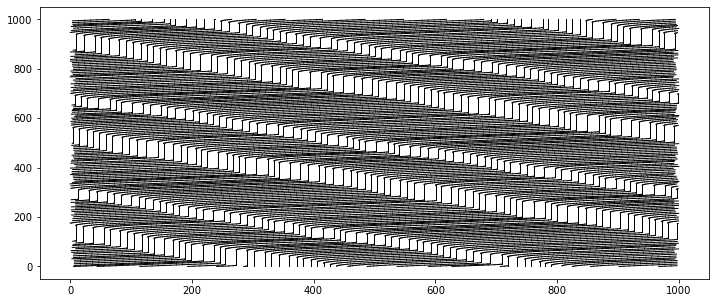

In [11]:
plot_positions(1000, 1, safe_lane_2, linewidth=1)

Again, we see that two jams are forming, one of them is very small and doesn't even take the cars to a complete stop. They move in the oposite direction to the cars. The rest of the time the cars move close to their max speed. To better compare it to the previous type of car we can repeat our experiments.

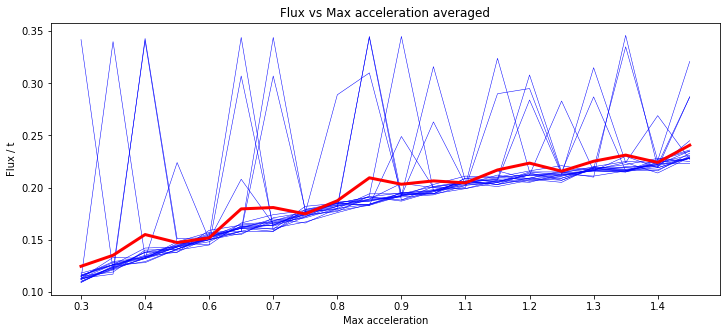

In [12]:
N = 20
accs = list(np.linspace(0.3, 1.5, 20))
flux_avg_accs_smart = np.zeros((len(accs), ))

for n in range(N):
    sim_arr = np.zeros((len(accs), ))
    for i in range(len(accs)):
        lane = OneLane(1000, [35], ["smart"], OneLaneCar, safe_dist = 20, 
                        accident_dist = 3, max_speed = 10, max_acc = accs[i], min_acc = -3)
        # Simulate lane
        _, _, flux, accidents = flux_and_accidents(1000, 1, lane)
        sim_arr[i] = flux

    plt.plot(sim_arr, 'blue', linewidth=.5)
    flux_avg_accs_smart += sim_arr
    
flux_avg_accs_smart /= N
plt.plot(flux_avg_accs_smart, 'red', linewidth=3)

plt.xlabel("Max acceleration")
plt.ylabel("Flux / t")
plt.xticks(range(0, len(accs), 2), [round(accs[j], 1) for j in range(0, len(accs), 2)])
plt.title("Flux vs Max acceleration averaged")
plt.show()

As we can see, the flux is also increasing with the max acceleration (as expected). However, this time there are some outliers, some simulations in which everything aligns perfectly and there are no jams. This cases bring the average a bit higher up. Something similar happens when variating the maximum speed:

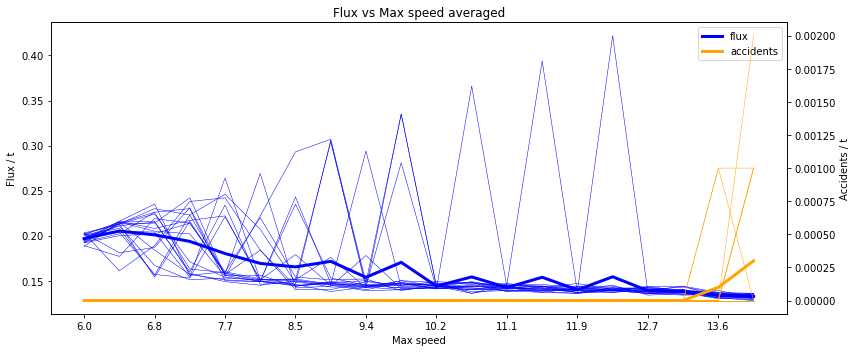

In [13]:
N = 20
sps = list(np.linspace(6, 14, 20))
flux_avg_sps_smart = np.zeros((len(sps), 2))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

for n in range(N):
    sim_arr = np.zeros((len(sps), 2))
    for i in range(len(sps)):
        lane = OneLane(1000, [35], ["smart"], OneLaneCar, safe_dist = 20, 
                        accident_dist = 3, max_speed = sps[i], max_acc = 0.5, min_acc = -3)
        # Simulate lane
        _, _, flux, accidents = flux_and_accidents(1000, 1, lane)
        sim_arr[i, :] = [flux, accidents]

    # plot it with a thin line
    ax1.plot(sim_arr[:, 0], 'blue', linewidth=0.5)
    ax2.plot(sim_arr[:, 1], 'orange', linewidth=0.5)
    flux_avg_sps_smart += sim_arr

flux_avg_sps_smart /= N
# Plot it with a thicker line.
ln1 = ax1.plot(flux_avg_sps_smart[:, 0], 'blue', linewidth=3)
ln2 = ax2.plot(flux_avg_sps_smart[:, 1], 'orange', linewidth=3)
ax1.legend(ln1+ln2, ["flux", "accidents"])
ax1.set_xlabel("Max speed")
ax1.set_ylabel("Flux / t")
ax2.set_ylabel("Accidents / t")
ax1.set_xticks(range(0, len(sps), 2))
ax1.set_xticklabels([round(sps[j], 1) for j in range(0, len(sps), 2)])
plt.title("Flux vs Max speed averaged")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

The result is very different to that of smart cars. Lets ignore the outliers for one second, after `max_speed = 8` the flux decreases slowly, with most runs being basically equal. Before that, the flux also decreases but more sharply and with much more variability. Now, interestingly, for higher values of maximum speed, more extreme outliers appear, which are those cases in which the situation aligns perfectly. Finally, there are almost never accidents, except for some outliers above the `max_speed = 13` value. This makes sense because this cars wont accelerate to their maximum capacity when approaching the car in front, so some accidents are avoided.

### Risky cars

Finally, we are going to talk about the **title of this project**. What do we mean by _risky drivers_? Well, a safe driver waits in the roundabout until there are no cars coming. On the other hand, a risky driver may see a car coming, but calculate that he has time enough to enter the roundabout and go for it.

So _risky drivers_ are the ones that trust their ability to estimate the speed of other cars and take decissions accordingly. Smart cars are already doing this since they are trying to match the speed of the car in front of them when driving. However, risky cars can do better. When approaching the front car, instead of fully braking as you enter the safe distance, _risky drivers_ may take into account that the car in front of them is moving. So this is the rule they follow: Once the safe distance has been entered...

1. If the car is moving faster than me, don't even brake. Aim for a speed a bit less than the front car (`target_speed = 0.9 * front_car_speed`).
2. If the car is moving slowlier than me, I must brake. But, as I brake I take into account his speed, so I don't always have to brake to the maximum speed. In fact, what I will do is aim for half of the speed of the car in front of me.

If this was a rule followed by human drivers, there would be risk involved. How good are we at estimating the speed of other cars? However, this is a computer, so no real risk is involved **YET** and we shoud just expect a better traffic flux. Lets run some simulations to see if this is true. We will directly jump to the saturated lane scenario:

In [14]:
risky_lane = OneLane(1000, [35], ["risky"], OneLaneCar, safe_dist = 20, 
                    accident_dist = 3, max_speed = 10, max_acc = 0.5, min_acc = -3)

simulate_lane(risky_lane, steps=1000, dt=1, width=1000, height=200, frame_rate=60)


Lane:  One lane
Total flux:  312
Total accidents:  0

Flux / time:  0.312

Accidents / time:  0.0


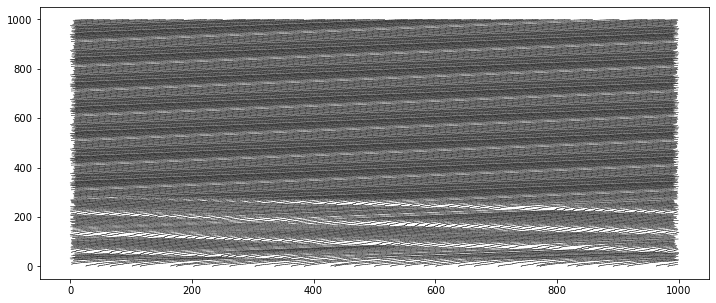

In [15]:
risky_lane = OneLane(1000, [35], ["risky"], OneLaneCar, safe_dist = 20, 
                    accident_dist = 3, max_speed = 10, max_acc = 0.5, min_acc = -3)
plot_positions(1000, 1, risky_lane, linewidth=0.5)

As we can see, most jams dissipate or become small. This is a huge result, because it means that our statement is correct. Risky drivers are good for traffic. How good? Lets run the same simulations and see.

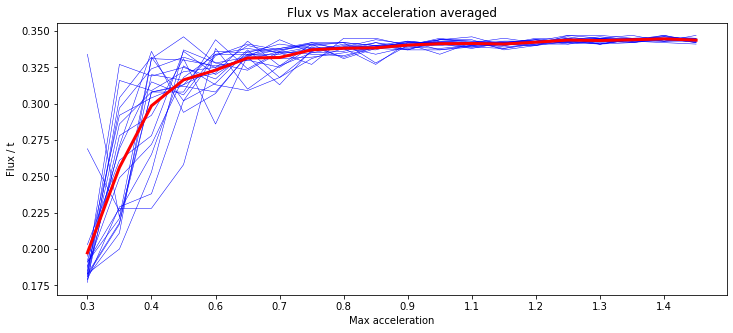

In [16]:
N = 20
accs = list(np.linspace(0.3, 1.5, 20))
flux_avg_accs_risky = np.zeros((len(accs), ))

for n in range(N):
    sim_arr = np.zeros((len(accs), ))
    for i in range(len(accs)):
        lane = OneLane(1000, [35], ["risky"], OneLaneCar, safe_dist = 20, 
                        accident_dist = 3, max_speed = 10, max_acc = accs[i], min_acc = -3)
        # Simulate lane
        _, _, flux, accidents = flux_and_accidents(1000, 1, lane)
        sim_arr[i] = flux

    plt.plot(sim_arr, 'blue', linewidth=.5)
    flux_avg_accs_risky += sim_arr
    
flux_avg_accs_risky /= N
plt.plot(flux_avg_accs_risky, 'red', linewidth=3)

plt.xlabel("Max acceleration")
plt.ylabel("Flux / t")
plt.xticks(range(0, len(accs), 2), [round(accs[j], 1) for j in range(0, len(accs), 2)])
plt.title("Flux vs Max acceleration averaged")
plt.show()

This small change in the car rules made a huge difference. The maximum acceleration seems now much more important to the flux. This makes sense since one of the biggest differences with _risky_ cars is that in jams, they will start moving as soon as the car in front of them does (not waiting until it exists the safe distance). So accelerating quickly plays an important role in jam-dissipation. We can observe that after `max_acc = 0.7` the flux plateaus since probably `max_speed` becomes the limiting factor at that point. We also observe a lot of variability for valeus below `0.7`.

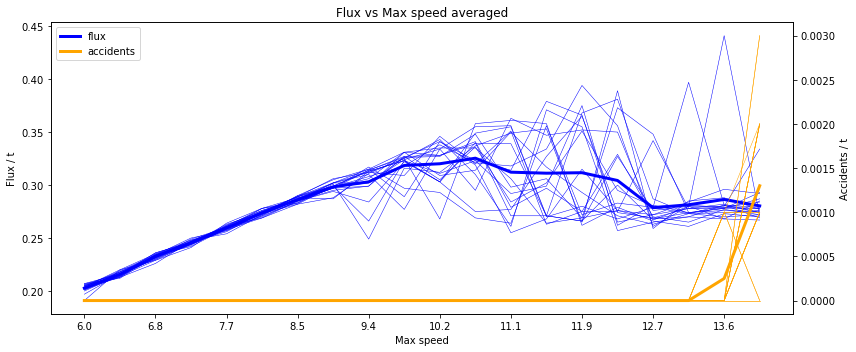

In [17]:
N = 20
sps = list(np.linspace(6, 14, 20))
flux_avg_sps_risky = np.zeros((len(sps), 2))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

for n in range(N):
    sim_arr = np.zeros((len(sps), 2))
    for i in range(len(sps)):
        lane = OneLane(1000, [35], ["risky"], OneLaneCar, safe_dist = 20, 
                        accident_dist = 3, max_speed = sps[i], max_acc = 0.5, min_acc = -3)
        # Simulate lane
        _, _, flux, accidents = flux_and_accidents(1000, 1, lane)
        sim_arr[i, :] = [flux, accidents]

    # plot it with a thin line
    ax1.plot(sim_arr[:, 0], 'blue', linewidth=0.5)
    ax2.plot(sim_arr[:, 1], 'orange', linewidth=0.5)
    flux_avg_sps_risky += sim_arr

flux_avg_sps_risky /= N
# Plot it with a thicker line.
ln1 = ax1.plot(flux_avg_sps_risky[:, 0], 'blue', linewidth=3)
ln2 = ax2.plot(flux_avg_sps_risky[:, 1], 'orange', linewidth=3)
ax1.legend(ln1+ln2, ["flux", "accidents"])
ax1.set_xlabel("Max speed")
ax1.set_ylabel("Flux / t")
ax2.set_ylabel("Accidents / t")
ax1.set_xticks(range(0, len(sps), 2))
ax1.set_xticklabels([round(sps[j], 1) for j in range(0, len(sps), 2)])
plt.title("Flux vs Max speed averaged")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Again, the results are very different. For small `max_speed`, the flow is optimized so we don't observe almost any variability, and a linear increase. At this values, any jams are quickly dissipated. Around `9.5` some problems begin to arise, namely, this speed is already high enough so that jams may form and it may cost more to dissipate them. After peaking at around `11`, the flow begins to decrease slowly with the `max_speed`, due to more sever jams forming. We can also see that the variability afeter `9.5` also increases considerably with the `max_speed`. At the peak value (`11`), the variability is high enough so that we may consider to decrease the `max_speed` in favor of more confidence about the flow.

Regarding the number of accidents, again, almost all of them are avoided by these types of cars, unless the `max_speed` takes really high values (above `13`).

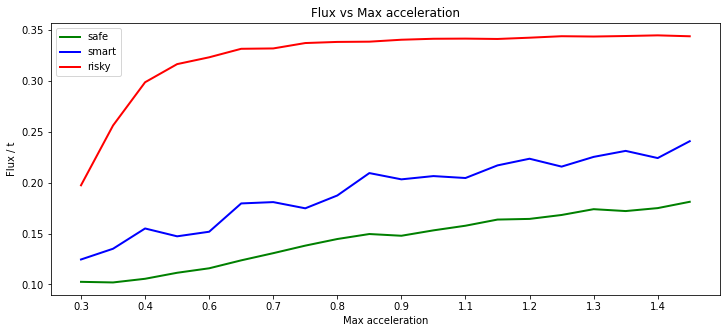

In [18]:
plt.plot(flux_avg_accs_safe, 'green', linewidth=2)
plt.plot(flux_avg_accs_smart, 'blue', linewidth=2)
plt.plot(flux_avg_accs_risky, 'red', linewidth=2)

plt.xlabel("Max acceleration")
plt.ylabel("Flux / t")
plt.xticks(range(0, len(accs), 2), [round(accs[j], 1) for j in range(0, len(accs), 2)])
plt.legend(["safe", "smart", "risky"])
plt.title("Flux vs Max acceleration")
plt.show()

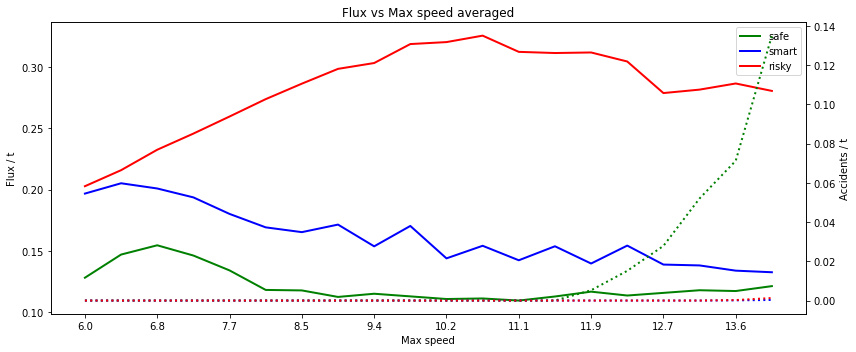

In [19]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ln1 = ax1.plot(flux_avg_sps_safe[:, 0], 'green', linewidth=2)
ln2 = ax2.plot(flux_avg_sps_safe[:, 1], 'green', linestyle = 'dotted', linewidth=2)
ln3 = ax1.plot(flux_avg_sps_smart[:, 0], 'blue', linewidth=2)
ln4 = ax2.plot(flux_avg_sps_smart[:, 1], 'blue', linestyle = 'dotted', linewidth=2)
ln5 = ax1.plot(flux_avg_sps_risky[:, 0], 'red', linewidth=2)
ln6 = ax2.plot(flux_avg_sps_risky[:, 1], 'red', linestyle = 'dotted', linewidth=2)
ax1.legend(ln1+ln3+ln5, ["safe", "smart", "risky"])

ax1.set_xlabel("Max speed")
ax1.set_ylabel("Flux / t")
ax2.set_ylabel("Accidents / t")
ax1.set_xticks(range(0, len(sps), 2))
ax1.set_xticklabels([round(sps[j], 1) for j in range(0, len(sps), 2)])
plt.title("Flux vs Max speed averaged")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


This leaves us with a nice image of the different cars performance. It clearly favours risky cars and it also states **there is an optimal maximum speed to allow for cars in roads with one single lane that maximizes the flux** without the risk of accidents, and without too much variability. Obviously to find this optimum we would need to adjust the model parameters to fit real data, which is not the purpose of this work.

### The risk of risky cars

So far, the advantage of risky cars is overwhelmingly positive. However, humans are not computers, and in real life we are subject to error. We might misscalculate the distance to the car in front of us, or it's speed. If we can emulate this in our simulation, we can have the cars compete in a more _fair_ environment.

So this is what we did. We added some noise into the cars readings. We can control the probability of missreading the speed and distance, as well as the magnitud of the error.

In [20]:
noise = {
    "dist": {"prob": 0.1, "mag": 2},
    "speed": {"prob": 0.5, "mag": 1}
}

noisy_safe_lane = OneLane(1000, [30], ["safe"], OneLaneCar, safe_dist = 20, 
                    accident_dist = 3, max_speed = 5, max_acc = 0.5, min_acc = -3, noise=noise)

simulate_lane(noisy_safe_lane, steps=1000, dt=1, width=1000, height=200, frame_rate=300)


Lane:  One lane
Total flux:  147
Total accidents:  0

Flux / time:  0.147

Accidents / time:  0.0


In [21]:
noisy_safe_lane_2 = OneLane(1000, [35], ["safe"], OneLaneCar, safe_dist = 20, 
                    accident_dist = 3, max_speed = 10, max_acc = 0.5, min_acc = -3, noise=noise)

simulate_lane(noisy_safe_lane_2, steps=1000, dt=1, width=1000, height=200, frame_rate=300)


Lane:  One lane
Total flux:  109
Total accidents:  0

Flux / time:  0.109

Accidents / time:  0.0


It seems that safe cars might be slightly affected by this ammount of noise. But to make sure we must run many simulations and check the results:

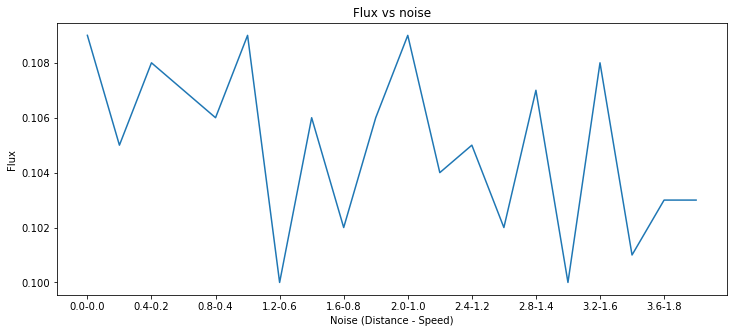

In [22]:
noises = []
for i in range(20):
    noise = {
        "dist": {"prob": 0.1, "mag": 4.*i/20},
        "speed": {"prob": 0.5, "mag": 2*i/20}
    }
    noises.append(noise)

safe_lane = OneLane(1000, [35], ["safe"], OneLaneCar, safe_dist = 20, 
                    accident_dist = 3, max_speed = 10, max_acc = 0.5, min_acc = -3)

fluxes, accidents = noises_flux(1000, 1, safe_lane, noises)

plt.plot(fluxes)
plt.xlabel("Noise (Distance - Speed)")
plt.ylabel("Flux")
plt.title("Flux vs noise")
plt.xticks(range(0, len(noises), 2), [ str(round(noises[i]["dist"]["mag"], 1)) + "-" + str(round(noises[i]["speed"]["mag"], 1)) for i in range(0, len(noises), 2) ] )
plt.show()

The variability seems very high, so we will have to run many simulations.

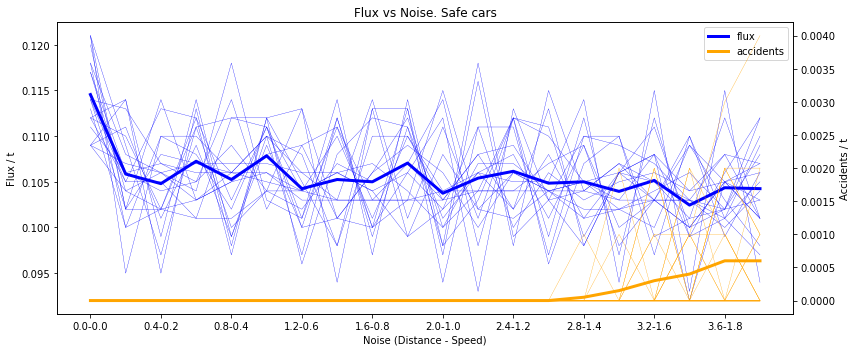

In [23]:
N = 20

avg_arr_safe = np.zeros((2, len(noises)))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

for n in range(N):
    
    lane = OneLane(1000, [35], ["safe"], OneLaneCar, safe_dist = 20, 
                    accident_dist = 6, max_speed = 10, max_acc = 0.5, min_acc = -3)
    # Simulate lane
    flux, accidents = noises_flux(1000, 1, lane, noises)

    sim_arr = np.vstack((flux, accidents))

    # plot it with a thin line
    ax1.plot(sim_arr[0, :], 'blue', linewidth=0.3)
    ax2.plot(sim_arr[1, :], 'orange', linewidth=0.3)
    avg_arr_safe += sim_arr

avg_arr_safe /= N
# Plot it with a thicker line.
ln1 = ax1.plot(avg_arr_safe[0, :], 'blue', linewidth=3)
ln2 = ax2.plot(avg_arr_safe[1, :], 'orange', linewidth=3)
ax1.legend(ln1+ln2, ["flux", "accidents"])
ax1.set_xlabel("Noise (Distance - Speed)")
ax1.set_ylabel("Flux / t")
ax2.set_ylabel("Accidents / t")
ax1.set_xticks(range(0, len(noises), 2))
ax1.set_xticklabels([ str(round(noises[i]["dist"]["mag"], 1)) + "-" + str(round(noises[i]["speed"]["mag"], 1)) for i in range(0, len(noises), 2) ] )
plt.title("Flux vs Noise. Safe cars")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Eventhough there is a lot of variability, as we expected, the effect on the flux for safe cars is not terrible. We do notice a slight decrease in flux as the noise increases. If ther is enough noise, we also nottice a increase in the number of accidents. (that maintains below `0.001/t`).

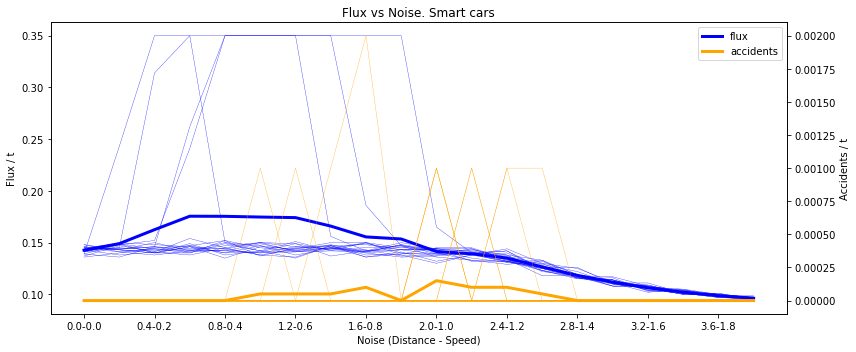

In [24]:
N = 20

avg_arr_safe = np.zeros((2, len(noises)))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

for n in range(N):
    
    lane = OneLane(1000, [35], ["smart"], OneLaneCar, safe_dist = 20, 
                    accident_dist = 7.5, max_speed = 10, max_acc = 0.5, min_acc = -3)
    # Simulate lane
    flux, accidents = noises_flux(1000, 1, lane, noises)

    sim_arr = np.vstack((flux, accidents))

    # plot it with a thin line
    ax1.plot(sim_arr[0, :], 'blue', linewidth=0.3)
    ax2.plot(sim_arr[1, :], 'orange', linewidth=0.3)
    avg_arr_safe += sim_arr

avg_arr_safe /= N
# Plot it with a thicker line.
ln1 = ax1.plot(avg_arr_safe[0, :], 'blue', linewidth=3)
ln2 = ax2.plot(avg_arr_safe[1, :], 'orange', linewidth=3)
ax1.legend(ln1+ln2, ["flux", "accidents"])
ax1.set_xlabel("Noise (Distance - Speed)")
ax1.set_ylabel("Flux / t")
ax2.set_ylabel("Accidents / t")
ax1.set_xticks(range(0, len(noises), 2))
ax1.set_xticklabels([ str(round(noises[i]["dist"]["mag"], 1)) + "-" + str(round(noises[i]["speed"]["mag"], 1)) for i in range(0, len(noises), 2) ] )
plt.title("Flux vs Noise. Smart cars")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

With smart cars again we find a lot of outliers. But if we ignore them, we can observe that at the beggining, noise doesn't affect much the result. When it is high enough we start to see a slight decrease. Without the outliers we could assume the accidents are almost always `0`.

If we now focus on the outliers, we can observe a very interesting result: For some reason, **a slight (but non-zero) ammount of noise helps the flux**. Most of the simulations wont nottice it, but sometimes the noise might help dissipate the jam, and thus, increase drastically the total flux. This also results in a road where all the cars are going really fast (maybe close to the `max_speed`), so in this cases some accidents might occurr (due to the noise again).

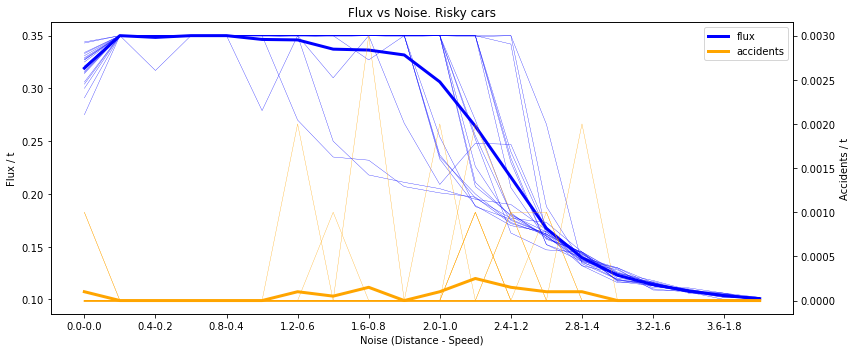

In [25]:
N = 20

avg_arr_safe = np.zeros((2, len(noises)))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

for n in range(N):
    
    lane = OneLane(1000, [35], ["risky"], OneLaneCar, safe_dist = 20, 
                    accident_dist = 9, max_speed = 10, max_acc = 0.5, min_acc = -3)
    # Simulate lane
    flux, accidents = noises_flux(1000, 1, lane, noises)

    sim_arr = np.vstack((flux, accidents))

    # plot it with a thin line
    ax1.plot(sim_arr[0, :], 'blue', linewidth=0.3)
    ax2.plot(sim_arr[1, :], 'orange', linewidth=0.3)
    avg_arr_safe += sim_arr

avg_arr_safe /= N
# Plot it with a thicker line.
ln1 = ax1.plot(avg_arr_safe[0, :], 'blue', linewidth=3)
ln2 = ax2.plot(avg_arr_safe[1, :], 'orange', linewidth=3)
ax1.legend(ln1+ln2, ["flux", "accidents"])
ax1.set_xlabel("Noise (Distance - Speed)")
ax1.set_ylabel("Flux / t")
ax2.set_ylabel("Accidents / t")
ax1.set_xticks(range(0, len(noises), 2))
ax1.set_xticklabels([ str(round(noises[i]["dist"]["mag"], 1)) + "-" + str(round(noises[i]["speed"]["mag"], 1)) for i in range(0, len(noises), 2) ] )
plt.title("Flux vs Noise. Risky cars")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Finally, for risky cars the result again is very different. The noise pretty much doesn't affect the flux until it is high enough. At that point, the flux experiments a drop. As we reach high amounts of noise the curve starts to plateau, indicating that probably these lanes are very jammed and thus, cars don't reach high enough speeds so that the noise will affect them that much.

We can see that even with noise many of the simulations display no accidents, but at the point where the flux starts to drop it is enough noise so that accidents are caused, but not too much noise so that jams will take over and cars won't go fast enough to cause accidents. Around that area (between `1.6-0.8` and `2.8-1.4`) many of the simulations display up to `0.003 / t` accidents.

### Mixing cars

Finally, in real life there are different driving styles. Some drivers are riskier than others. Overall, there is a total amount of risk in the road at any given time which can be associated to how risky each of it's drivers is. To emulate this, we can have lanes where some of the cars are `risky` but others are `smart`.

We want to check for two things:

1. First, how does the proportion of risky drivers affect the flux and accidents on the normal scenario.
2. How does the proportion of risky drivers affect the flux and accidents on the noisy scenario.


In [26]:
mixed_lane = OneLane(1000, [20, 15], ["safe", "risky"], OneLaneCar, safe_dist = 20, 
                    accident_dist = 3, max_speed = 10, max_acc = 0.5, min_acc = -3)

simulate_lane(mixed_lane, steps=1000, dt=1, width=1000, height=200, frame_rate=300)


Lane:  One lane
Total flux:  143
Total accidents:  0

Flux / time:  0.143

Accidents / time:  0.0


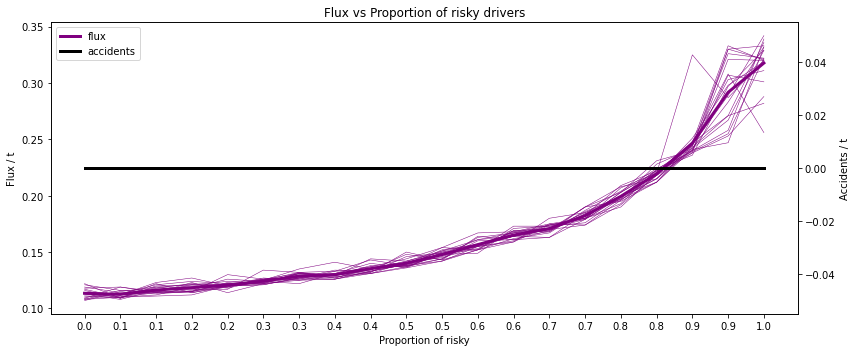

In [27]:
N = 20
total_cars = 35

proportions = list(np.linspace(0, 1, 20))
flux_avg_mixed = np.zeros((len(proportions), 2))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

for n in range(N):
    sim_arr = np.zeros((len(proportions), 2))
    for i in range(len(proportions)):

        risky_cars = int(proportions[i] * total_cars)
        lane = OneLane(1000, [risky_cars, total_cars - risky_cars], ["risky", "safe"], OneLaneCar, safe_dist = 20, 
                        accident_dist = 3, max_speed = 10, max_acc = 0.5, min_acc = -3)
        # Simulate lane
        _, _, flux, accidents = flux_and_accidents(1000, 1, lane)
        sim_arr[i, :] = [flux, accidents]

    ax1.plot(sim_arr[:, 0], 'purple', linewidth=.5)
    ax2.plot(sim_arr[:, 1], 'black', linestyle='dotted', linewidth=0.5)
    flux_avg_mixed += sim_arr
    
flux_avg_mixed /= N

# Plot it with a thicker line.
ln1 = ax1.plot(flux_avg_mixed[:, 0], 'purple', linewidth=3)
ln2 = ax2.plot(flux_avg_mixed[:, 1], 'black', linewidth=3)
ax1.legend(ln1+ln2, ["flux", "accidents"])
ax1.set_xlabel("Proportion of risky")
ax1.set_ylabel("Flux / t")
ax2.set_ylabel("Accidents / t")
ax1.set_xticks(range(len(proportions)))
ax1.set_xticklabels([round(proportions[j], 1) for j in range(len(proportions))])
plt.title("Flux vs Proportion of risky drivers")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

As expected, on the normal scenario, having more risky drivers increases the flux. In fact, the displayed curve is concave, so adding more risky cars at the beggining doesn't affect the result as much as adding more risky cars when there is already almost no safe cars left. 

We can also see that **risky drivers add variability** to the flux, so we might want to keep at least some `safe` drivers on the road. The number of accidents doesn't increase much because there is no noise.

Now lets repeat the simulation with a considerable different ammounts of nosie

In [28]:
N = 40
total_cars = 35

little_noise = {
    "dist": {"prob": 0.1, "mag": 1.2},
    "speed": {"prob": 0.5, "mag": 0.6}
}
medium_noise = {
    "dist": {"prob": 0.1, "mag": 2.4},
    "speed": {"prob": 0.5, "mag": 1.2}
}
large_noise = {
    "dist": {"prob": 0.1, "mag": 3},
    "speed": {"prob": 0.5, "mag": 1.5}
}

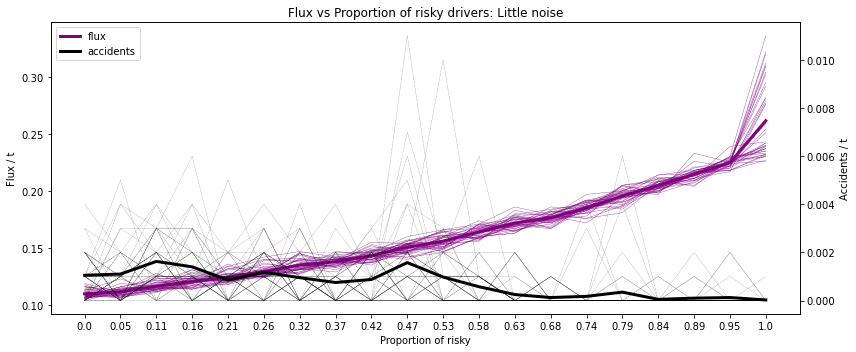

In [32]:
proportions = list(np.linspace(0, 1, 20))
flux_avg_mixed = np.zeros((len(proportions), 2))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

for n in range(N):
    sim_arr = np.zeros((len(proportions), 2))
    for i in range(len(proportions)):

        risky_cars = int(proportions[i] * total_cars)
        lane = OneLane(1000, [risky_cars, total_cars - risky_cars], ["risky", "safe"], OneLaneCar, safe_dist = 20, 
                        accident_dist = 8, max_speed = 10, max_acc = 0.5, min_acc = -3, noise = little_noise)
        # Simulate lane
        _, _, flux, accidents = flux_and_accidents(1000, 1, lane)
        sim_arr[i, :] = [flux, accidents]

    ax1.plot(sim_arr[:, 0], 'purple', linewidth=.3)
    ax2.plot(sim_arr[:, 1], 'black', linestyle='dotted', linewidth=0.3)
    flux_avg_mixed += sim_arr
    
flux_avg_mixed /= N

# Plot it with a thicker line.
ln1 = ax1.plot(flux_avg_mixed[:, 0], 'purple', linewidth=3)
ln2 = ax2.plot(flux_avg_mixed[:, 1], 'black', linewidth=3)
ax1.legend(ln1+ln2, ["flux", "accidents"])
ax1.set_xlabel("Proportion of risky")
ax1.set_ylabel("Flux / t")
ax2.set_ylabel("Accidents / t")
ax1.set_xticks(range(len(proportions)))
ax1.set_xticklabels([round(proportions[j], 2) for j in range(len(proportions))])
plt.title("Flux vs Proportion of risky drivers: Little noise")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

As we can see, with no little there is no effect and we get the same result as with no noise.

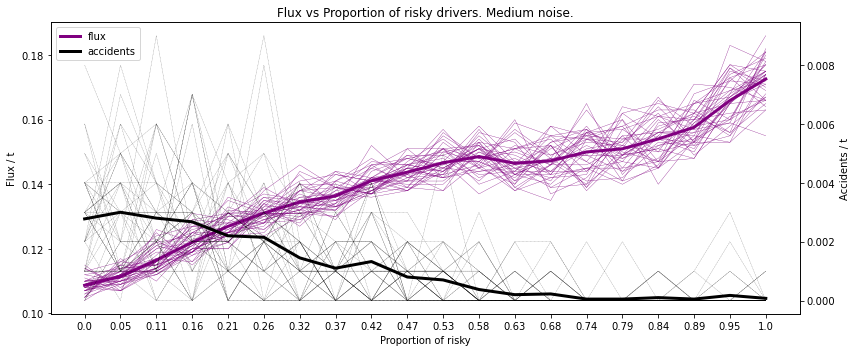

In [30]:
proportions = list(np.linspace(0, 1, 20))
flux_avg_mixed = np.zeros((len(proportions), 2))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

for n in range(N):
    sim_arr = np.zeros((len(proportions), 2))
    for i in range(len(proportions)):

        risky_cars = int(proportions[i] * total_cars)
        lane = OneLane(1000, [risky_cars, total_cars - risky_cars], ["risky", "safe"], OneLaneCar, safe_dist = 20, 
                        accident_dist = 8, max_speed = 10, max_acc = 0.5, min_acc = -3, noise = medium_noise)
        # Simulate lane
        _, _, flux, accidents = flux_and_accidents(1000, 1, lane)
        sim_arr[i, :] = [flux, accidents]

    ax1.plot(sim_arr[:, 0], 'purple', linewidth=.3)
    ax2.plot(sim_arr[:, 1], 'black', linestyle='dotted', linewidth=0.3)
    flux_avg_mixed += sim_arr
    
flux_avg_mixed /= N

# Plot it with a thicker line.
ln1 = ax1.plot(flux_avg_mixed[:, 0], 'purple', linewidth=3)
ln2 = ax2.plot(flux_avg_mixed[:, 1], 'black', linewidth=3)
ax1.legend(ln1+ln2, ["flux", "accidents"])
ax1.set_xlabel("Proportion of risky")
ax1.set_ylabel("Flux / t")
ax2.set_ylabel("Accidents / t")
ax1.set_xticks(range(len(proportions)))
ax1.set_xticklabels([round(proportions[j], 2) for j in range(len(proportions))])
plt.title("Flux vs Proportion of risky drivers. Medium noise.")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

When the noise is medium, the curve is more concave meaning that adding a few risky drivers at the beggining has more effect than adding them when there are already a lot of risky drivers. We can also see how **the amount of accidents decreases when you add more risky drivers** with this amount of noise. This is a very counter-intuitive resultnd not at all what we expected when we began this project.

> TODO: Our hypothesis on why this happens? Maybe the safe drivers are really not good with noise?.

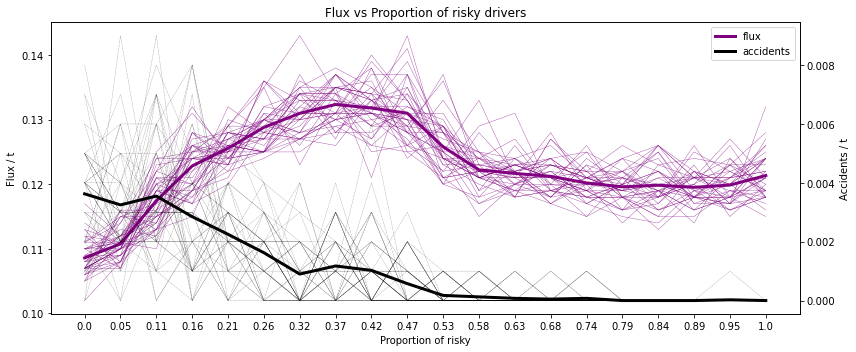

In [31]:
proportions = list(np.linspace(0, 1, 20))
flux_avg_mixed = np.zeros((len(proportions), 2))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

for n in range(N):
    sim_arr = np.zeros((len(proportions), 2))
    for i in range(len(proportions)):

        risky_cars = int(proportions[i] * total_cars)
        lane = OneLane(1000, [risky_cars, total_cars - risky_cars], ["risky", "safe"], OneLaneCar, safe_dist = 20, 
                        accident_dist = 8, max_speed = 10, max_acc = 0.5, min_acc = -3, noise = large_noise)
        # Simulate lane
        _, _, flux, accidents = flux_and_accidents(1000, 1, lane)
        sim_arr[i, :] = [flux, accidents]

    ax1.plot(sim_arr[:, 0], 'purple', linewidth=.3)
    ax2.plot(sim_arr[:, 1], 'black', linestyle='dotted', linewidth=0.3)
    flux_avg_mixed += sim_arr
    
flux_avg_mixed /= N

# Plot it with a thicker line.
ln1 = ax1.plot(flux_avg_mixed[:, 0], 'purple', linewidth=3)
ln2 = ax2.plot(flux_avg_mixed[:, 1], 'black', linewidth=3)
ax1.legend(ln1+ln2, ["flux", "accidents"])
ax1.set_xlabel("Proportion of risky")
ax1.set_ylabel("Flux / t")
ax2.set_ylabel("Accidents / t")
ax1.set_xticks(range(len(proportions)))
ax1.set_xticklabels([round(proportions[j], 2) for j in range(len(proportions))])
plt.title("Flux vs Proportion of risky drivers")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

This is our last graph and by far the weirdest result. When there is a _large_ (again, we don't know how this extrapolates to real human drivers) noise, we observe an interesting behavior. As we start adding risky drivers the flux rapidly increases, up to 0.4 where the flux peaks. Then it starts to slowly decrease as more and more risky drivers are added. Finally, it increases again when the amount of safe drivers drops below 10%.

The amount of accidents continuosly drops as we add risky drivers, all the way down to 0.

An interesting insight is that **the maximum flux is attained when there is a mix of safe and risky cars on the road**. Eventhough by themselves risky cars are better than safe cars, a mix of both is better than any of them isolated.

## Next steps:

1. Try to extract parameters from real world data to see if the model fits and if some of our conclussions can be applied.
2. There is in internet some simulations that if each car tries to maintain the same distance to the previous and next car, the jams are dissipated and the flux in the lane is smooth. This rule may not have much real-world applications because of how humans drive, but it would be interesting to test it in our model.
3. Simulate other scenarios such as multiple-lane roads and roundabouts.